In [1]:
### ========= SIAMESE NETWORK CODE FOR SUBJECT MATCHING (MNIT Dataset) =======
## Note. This run on GPU


### --------- IMPORT PACKAGES
import torch
import torch.nn as nn
import torch.nn.functional as F
#data handling
import numpy as np
import random
#plotting
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torch import optim
from torch.utils.data import random_split
#ROC AUC curve
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
#image loading
from google.colab import files
from PIL import Image, ImageOps
import io
#save on drive
from google.colab import drive


### --------- CLASSES DEFINTIONS

## --- PAIRED IMAGES DATASET BUILDING
class SiameseData(Dataset):
    ''' Define a custom class (dataset + transform) to build a Siamese (i.e paired imaged) datatset
    starting from a given dataset and a given transform.
    Returns img1, img2 and the matching label
    '''
    #stores the dataset and optional transform for later use
    def __init__(self, data, transform=None):
        # Save the dataset (e.g., training or validation set) as an instance variable
        self.data = data
        # Save the transform as an instance variable
        self.transform = transform

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    #returns 1 sample (pair of imgs) given an index
    def __getitem__(self,index):
        #select img1 and its label
        img1, label1 = self.data[index]

        #randomly decide if picking a matching label (same class = 1) or different labels (same class = 0) pair
        same_class = random.randint(0, 1)

        # the pair MUST have a matching label (same class)
        if same_class == 1:
            #initilize label2 (with a value not included in MNIST (goes from 0-9))
            label2 = -1
            #loop to keep picking until a label match is found (stops when label2 == label1)
            while label2 != label1:
                #randomly picks and img and its label to compare with label1
                img2, label2 = random.choice(self.data)

        #the pair MUST NOT have a matching label (different classes)
        else:
            #initilize label 2 = label1
            label2 = label1
            #loop to keep picking until a different label pic is found (stops when label2 != label1)
            while label2 == label1:
                #randomly picks and img and its label to compare with label1
                img2, label2 = random.choice(self.data)

        # once a an img2 (either = or different) has been found transform both the imgs
        if self.transform: #(if a transform was defined)
            #apply transform to img1
            img1 = self.transform(img1)
            #apply transform to img2
            img2 = self.transform(img2)

        #define the pair_label (1 if labels differ, else 0 (base case))
        pair_label = torch.tensor([(label1 != label2)], dtype = torch.float32)
        #check if labels are different, if are the output is True -> pytorch converts to 1

        #return imgs pair and their label
        return img1, img2, pair_label


## --- CONTRASTIVE LOSS FUNCTION (custom loss function class for contrastive learning)
class ContrastLoss(torch.nn.Module):
    # Initialize the class, setting a 'margin' (minimum distance between embeddings of different classes)
    def __init__(self, margin = 2.0):
        # Inherit from PyTorch's base class for all neural network modules
        super(ContrastLoss, self).__init__()
        # Save the margin as an attribute of the loss function
        self.margin = margin

    # Define how the loss is computed for each batch
    def forward(self, output1, output2, y):
        # Compute the Euclidean distance  (between the two outputs)
        euclid_dist = F.pairwise_distance(output1, output2, keepdim = True)

        #similar pairs (y = 0): minimize the squared distance between embeddings
        same_class_loss = (1 - y) * (euclid_dist ** 2)

        # different pairs (y = 1): penalize only if the distance is smaller than the margin
        diff_class_loss = (y) * (torch.clamp(self.margin - euclid_dist, min = 0.0) ** 2)
        # Note. this encourages diff pairs to be at least 'margin' apart

        # take the mean of losses
        return torch.mean(same_class_loss + diff_class_loss)


## --- TUNING CONVOLUTIONAL NEURAL NETWORK (adding BATCH)
class SiameseNetworkBatch(nn.Module):
    ''' Siamese Network for tuning. Configuration is equal to the SiameseNetwork except for the addition of
    Batch Normalization in the convolutional layers.
    '''
    #initialize the base nn.module class
    def __init__(self):
        super(SiameseNetworkBatch, self).__init__()

        # (3) convolutional layers to extract features from img
        self.cnn = nn.Sequential(
            #1st layer
            nn.Conv2d(1, 64, kernel_size = 5, stride = 1, padding = 2), #1 input channel -> 64 output channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True), #RELU activation function
            nn.MaxPool2d(2, stride = 2), #max pooling downsampling

            #2nd layer
            nn.Conv2d(64, 128, kernel_size = 5, stride = 1, padding = 2), #64 input channels -> 128 outpts channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            #3rd layer (smaller filter size, same pixel moving each step, smaller border )
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1), #128 input channels -> 256 outpts channels
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        # Fully connected layers to convert CNN features into embeddings
        self.fc = nn.Sequential(
            #flats the CNN output and maps it to 1024 features
            nn.Linear(256 * 3 * 3, 1024),
            #apply ReLU activation
            nn.ReLU(inplace = True),

            #reduces dimensionality (to 256)
            nn.Linear(1024, 256),
            #activation function
            nn.ReLU(inplace = True),
            #final embedding to 2, used to compute distances
            nn.Linear(256,2)
        )

    #compute the embedding for 1img
    def forward_once(self, x):
        #pass the img to the cnn to extract features
        output = self.cnn(x)
        #flat the cnn output into a 1D vector x img
        output = output.view(output.size()[0], -1)
        #pass through fully connected layers to get the embedding
        output = self.fc(output)
        #get the output
        return output

    #compute the embedding for a imgs PAIR (used to measure similarity)
    def forward(self, input1, input2):
        #get embedding on the 1st img
        output1 = self.forward_once(input1)
        #get embedding on the 2nd img
        output2 = self.forward_once(input2)
        #get embedding for both imgs
        return output1, output2


## --- TUNING EVALUATION FUNCTION
def evaluate(model, dataloader_val, criterion):
    """
    Evaluate a trained Siamese network on the validation set.
    Returns the average validation loss over all batches.
    """
    model.eval()
    val_total_loss = 0.0

    with torch.no_grad():
        for img1, img2, pair_label in dataloader_val:
            img1, img2, pair_label = img1.cuda(), img2.cuda(), pair_label.cuda()

            # Forward pass
            output1, output2 = model(img1, img2)
            val_loss_contrast = criterion(output1, output2, pair_label)

            val_total_loss += val_loss_contrast.item()

    avg_loss = val_total_loss / len(dataloader_val)
    return avg_loss


## --- SIMILARITY SCORE
def compute_similarity(output1, output2):
    # Compute Euclidean distance
    euclidean_distance = F.pairwise_distance(output1, output2)
    # Transform into similarity score in [0,1]
    similarity_score = torch.exp(-euclidean_distance)
    #return the score
    return similarity_score

In [2]:
#### =========== DATA & MODEL LOADING & DEFINITION

## --- DATA LOADING
#load the testing set
data_tt = MNIST(root = './data', train = False, download = True)
#define transformation pipeline convertin MNIST images from PIL to tensors
transform = transforms.Compose([transforms.ToTensor()])


## --- DATA TRANSFORMATION & PAIRING
# set up the various classes (original dataset + transform)
#testing
siamese_tt = SiameseData(data_tt, transform)


## --- DATALOADER, MODEL, OPTIMIZER AND LOSS FUNCTION DEFINITION
# contrastive loss function
crit = ContrastLoss()

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.87MB/s]


In [3]:
#### =========== MODEL LOADING & DEFINITION
tun_model = SiameseNetworkBatch().cuda()
#access to drive
drive.mount('/content/drive')
#load the already tuned model
tun_model.load_state_dict(torch.load("/content/drive/MyDrive/Siamese_model.pt"))
print("✅ Tuned model successfully loaded from 'Siamese_model.pt'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Tuned model successfully loaded from 'Siamese_model.pt'


✅ Reproducibility set: all seeds fixed to 42


Saving Unknown.jpeg to Unknown.jpeg


/tmp/ipython-input-3760745053.py:93: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


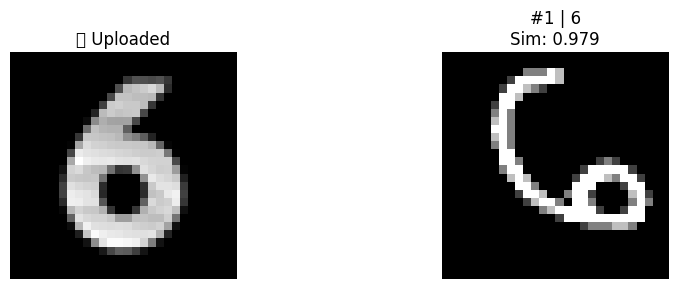

The uploaded img is a 6


In [14]:
### =========== MATCHING IMAGE & NUMBER IDENTIFICATION

#set the seed for reprod
SEED = 42
# Python random seed
random.seed(SEED)
# NumPy random seed
np.random.seed(SEED)
# PyTorch seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Ensure deterministic behavior in cuDNN (slower but repeatable)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#show if it is done
print(f"✅ Reproducibility set: all seeds fixed to {SEED}")

#prompt to upload an image file (showing a 1-digit number)
uploaded = files.upload()

#load and preprocess the uploaded image
#Note. MNIT imgs are black back-white digits -> need to transform the uploaded img
#into this layout
for filename in uploaded.keys():
  #load uploaded img from memory
    img = Image.open(io.BytesIO(uploaded[filename]))  # load image
    #convert to grayscale (MNIST files are grayscale)
    gray_img = img.convert("L")  # single channel
    #convert to numpy array
    gray_np = np.array(gray_img)
    #if img's back is bright (white) invert colors
    if np.mean(gray_np) > 127:
        gray_img = ImageOps.invert(gray_img)
    #resize to MNIST standards (28x28 pixels)
    gray_img = gray_img.resize((28, 28))
    #convert to tensor and add batch dimension (for model input)
    user_img = transforms.ToTensor()(gray_img).unsqueeze(0).cuda()

    #compute embedding of the uploaded image thanks to the CNN
    tun_model.eval() #set model in evaluation mode
    #no gradient computation
    with torch.no_grad():
        user_embed = tun_model.forward_once(user_img)

    #arrange a pool of test imgs for comparison
    #compare against entire test set
    n_samples = len(data_tt)
    #store img tensors
    test_imgs = []
    #store true digits labels
    test_labels = []
    #store embeddings
    test_embeds = []

    #loop over all test imgs
    for i in range(n_samples):
      #extract test img and its label
        test_img, test_label = data_tt[i]
        #apply same pre-processing (re-size + tensor conversion)
        test_img_proc = transforms.ToTensor()(test_img.resize((28, 28)))
        #save pre-processed img
        test_imgs.append(test_img_proc.squeeze().numpy())
        #and its label
        test_labels.append(test_label)
        #compute embedding for the test img
        with torch.no_grad():
            test_embeds.append(tun_model.forward_once(test_img_proc.unsqueeze(0).cuda()))

    #compute euclidean distance between uploaded img and all test imgs
    distances = [F.pairwise_distance(user_embed, e).item() for e in test_embeds]

    #Show the most similar img (smaller distance)
    #Note. tweak this to show the n-top similar images
    top_idx = np.argsort(distances)[:1]
    top_matches = [test_imgs[i] for i in top_idx]
    top_labels = [test_labels[i] for i in top_idx]
    #convert distance into similarity score (higher = more similar)
    top_scores = [np.exp(-distances[i]) for i in top_idx]

    #display the upload img + its closest match
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    #show uploaded img
    axes[0].imshow(user_img.cpu().squeeze().numpy(), cmap="gray")
    axes[0].set_title("🔹 Uploaded")
    axes[0].axis("off")
    #show the most similar test img
    for j in range(1):
        axes[j+1].imshow(top_matches[j], cmap="gray")
        axes[j+1].set_title(f"#{j+1} | {top_labels[j]}\nSim: {top_scores[j]:.3f}")
        axes[j+1].axis("off")
    #show plot
    plt.tight_layout()
    plt.show()

    #print the output
    print("=======================================")
    print(f"The uploaded img is a {top_labels[j]}")
    print("=======================================")


In [16]:
!git clone https://github.com/Lulloooo/SiameseNet-NumRecognition.git

Cloning into 'SiameseNet-NumRecognition'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [18]:
# Remove any previous local copy and clone a fresh one
!rm -rf SiameseNet-NumRecognition
!git clone https://github.com/Lulloooo/SiameseNet-NumRecognition.git

Cloning into 'SiameseNet-NumRecognition'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [19]:
REPO = "SiameseNet-NumRecognition"
# Paths to your Colab notebooks and model files
NOTEBOOK1="/content/drive/MyDrive/Colab_Notebooks/Siamese_Train&Evaluation.ipynb"
NOTEBOOK2="/content/drive/MyDrive/Colab_Notebooks/Siamese_predict.ipynb"
MODEL1="/content/drive/MyDrive/tuning_siamese_model.pt"
MODEL2="/content/drive/MyDrive/Siamese_model.pt"

# Copy them into the cloned repo
!cp "$NOTEBOOK1" "$REPO/"
!cp "$NOTEBOOK2" "$REPO/"
!cp "$MODEL1" "$REPO/"
!cp "$MODEL2" "$REPO/"


In [20]:
# Go into the repo directory
%cd $REPO

# Configure git (only once per Colab session)
!git config user.email "lucagabri98@live.com"
!git config user.name "Lulloooo"

# Add and commit the new files
!git add .
!git commit -m "Added Siamese training and prediction notebooks + model files"

# Push to GitHub
!git push origin main


/content/SiameseNet-NumRecognition
[main 3714aef] Added Siamese training and prediction notebooks + model files
 4 files changed, 2 insertions(+)
 create mode 100644 Siamese_Train&Evaluation.ipynb
 create mode 100644 Siamese_model.pt
 create mode 100644 Siamese_predict.ipynb
 create mode 100644 tuning_siamese_model.pt
fatal: could not read Username for 'https://github.com': No such device or address


In [25]:
!zip -r /content/SiameseNet_Files.zip \
    /content/drive/MyDrive/Colab_Notebooks/Siamese_TrainAndEvaluation.ipynb \
    /content/drive/MyDrive/Colab_Notebooks/Siamese_predict.ipynb \
    /content/drive/MyDrive/Siamese_model.pt \
    /content/drive/MyDrive/tuning_siamese_model.pt


	zip warning: name not matched: /content/drive/MyDrive/Colab_Notebooks/Siamese_TrainAndEvaluation.ipynb
  adding: content/drive/MyDrive/Colab_Notebooks/Siamese_predict.ipynb (deflated 58%)
  adding: content/drive/MyDrive/Siamese_model.pt (deflated 8%)
  adding: content/drive/MyDrive/tuning_siamese_model.pt (deflated 9%)
